# Summary

There are two main sections.

1: Basic data exploration

2: Data cleaning and processing

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# Basic EDA

In [97]:
df = pd.read_csv('trump_tweets.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date').reset_index(drop=True)
df = df.rename(columns={"favorites":"likes"})
df['month'] = df.date.apply(lambda x: x.month)
df['year'] = df.date.apply(lambda x: x.year)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56571 entries, 0 to 56570
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        56571 non-null  int64         
 1   text      56571 non-null  object        
 2   device    56571 non-null  object        
 3   likes     56571 non-null  int64         
 4   retweets  56571 non-null  int64         
 5   date      56571 non-null  datetime64[ns]
 6   month     56571 non-null  int64         
 7   year      56571 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 3.5+ MB
None


In [98]:
df.head()

,id,text,device,likes,retweets,date,month,year
0,1698308935,Be sure to tune in and watch Donald Trump on L...,Twitter Web Client,939,519,2009-05-04 18:54:00,5,2009
1,1701461182,Donald Trump will be appearing on The View tom...,Twitter Web Client,259,34,2009-05-05 01:00:00,5,2009
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,Twitter Web Client,37,15,2009-05-08 13:38:00,5,2009
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,Twitter Web Client,29,11,2009-05-08 20:40:00,5,2009
4,1773561338,"""""""My persona will never be that of a wallflow...",Twitter Web Client,1877,1321,2009-05-12 14:07:00,5,2009


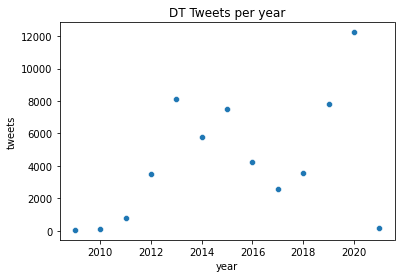

In [94]:
tweets_per_year = df.groupby('year').agg('count')['id']
_ = sns.scatterplot(data=tweets_per_year)
plt.ylabel('tweets')
plt.title('DT Tweets per year')
plt.show()

In [251]:
def at_mention(text):
    text = text.split()
    targets = []
    remove_chars = r'[:.\\!,\"?;()/=$#~`\'\[\]-]'
    for word in text:
        if '@' in word:
            w = re.sub(remove_chars, '', word).strip()
            if w[0] != '@':
                w = w[w.find('@'):]
            targets.append(w)
    if len(targets) == 0:
        targets = ['None']
    return targets

In [252]:
# Mentions
tweet_mentions = list(df.text.apply(lambda x: at_mention(x)))
tweet_mentions = list(filter(lambda x: (x != ['None']) and (x != ['@']), tweet_mentions))

mention_count = Counter()
for mentions in tweet_mentions:
    for mention in mentions:
        mention_count[mention]+=1
        
mention_list = [x[0] for x in mention_count.most_common(100)]

In [253]:
mention_df = pd.DataFrame(mention_list, columns=['mention'])
mention_df['total_count'] = mention_df.mention.apply(lambda x: df.text.apply(lambda y: x in y).sum())
mention_df['in_RT'] = mention_df.mention.apply(lambda x: df.text.apply(lambda y: (x in y) & ('RT' in y[:3])).sum())
mention_df['in_quote'] = mention_df.mention.apply(lambda x: df.text.apply(lambda y: (x in y) & ('"""' in y[:3])).sum())
mention_df['specific_mentions'] = mention_df.mention.apply(lambda x: \
    df.text.apply(lambda y: (x in y) & ('RT' not in y[:3]) & ('"""' not in y[:3])).sum())
mention_df

,mention,total_count,in_RT,in_quote,specific_mentions
0,@realDonaldTrump,10880,2623,8145,112
1,@FoxNews,963,98,212,653
2,@WhiteHouse,845,712,0,133
3,@foxandfriends,702,83,170,449
4,@BarackObama,726,7,29,690
...,...,...,...,...,...
95,@RepMattGaetz,52,52,0,0
96,@mcuban,51,0,18,33
97,@DRUDGE_REPORT,50,24,16,10
98,@BuckSexton,49,49,0,0


In [272]:
# Gut Check
(mention_df['total_count'] < (mention_df['in_RT'] + mention_df['in_quote'] + mention_df['specific_mentions'])).sum()

0

# Data Cleaning Tasks
## 1. HTML escape characters
    Escape characters for ampersands and other HTML characters are handled and cleaned
## 2. New line characters
    New line characters are removed
## 3. hyperlinks
    Hyperlinks are removed
## 4. Twitter Functionality
    a. Quotes are identified
    b. Retweets are identified
    c. @'s are included
    d. #'s are included

In [77]:
# Cleaning Functions

def split_ampersands(input_string):
    split = input_string.split('&')
    output = ''
    for item in split:
        output += item +'& '
    return output[:-2]

def white_space_remover(input_df):
    while input_df.text.apply(lambda x: '  ' in x).sum() > 0:
        input_df.text = input_df.text.apply(lambda x: x.replace('  ', ' '))

def hyperlink_remover(input_text):
    t = input_text.split()
    output_string = ""
    for word in t:
        if "http" in word:
            start=word.find("http")
            s = " " + word[:start]
            output_string += s
            output_string = output_string.strip()
        else:
            output_string += (" " + word)
            output_string = output_string.strip()
    return output_string

def is_retweet(input_string):
    return 'RT' in input_string[:5]

def is_quote(input_string):
    return input_string[:3] == '"""'

def blanker(input_string, condition = False):
    if condition:
        return ''
    else:
        return input_string

In [78]:
# Full Clean

def text_cleaner(input_df, drop_rt = False, drop_quote = False):
    output_df = input_df.copy()
    
    # Clean up HTML escape characters
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&amp;', '&')).apply(lambda x: x.replace('&amp','&'))
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&,', '&')).apply(lambda x: x.replace('&,', '&'))
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&…', '...')).apply(lambda x: x.replace('&...', '...'))
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&gt;', '>')).apply(lambda x: x.replace('&gt','>'))
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&lt;', '<')).apply(lambda x: x.replace('&lt','<'))
    
    # Fix ampersands
    output_df['text'] = output_df.text.apply(lambda x: split_ampersands(x)) 
    white_space_remover(output_df)
    
    # Clean out new line characters
    while output_df.text.apply(lambda x: ' \n' in x).sum() >0 :
        output_df['text'] = output_df.text.apply(lambda x: x.replace(' \n', '. '))
        white_space_remover(output_df)
    
    while output_df.text.apply(lambda x: '\n' in x).sum() > 0:
        output_df['text'] = output_df.text.apply(lambda x: x.replace('\n', '. '))
        white_space_remover(output_df)
    
    # Remove hyperlinks
    output_df['text'] = output_df.text.apply(lambda x: hyperlink_remover(x))
    white_space_remover(output_df)
    
    if drop_rt:
        output_df['text'] = output_df.text.apply(lambda x: blanker(x, is_retweet(x)))
    
    if drop_quote:
        output_df['text'] = output_df.text.apply(lambda x: blanker(x, is_quote(x)))
    
    # Clear out tweets that have been blanked
    output_df['text'] = output_df.text.apply(lambda x: x if ((len(str(x))>0) & (str(x)!='nan'))else np.nan)
    output_df.dropna(inplace=True)
    
    return output_df



In [90]:
clean_df = text_cleaner(df, True, True)
full_df = text_cleaner(df)

In [80]:
clean_df.head()

,id,text,device,likes,retweets,date,month,year
0,1698308935,Be sure to tune in and watch Donald Trump on L...,Twitter Web Client,939,519,2009-05-04 18:54:00,5,2009
1,1701461182,Donald Trump will be appearing on The View tom...,Twitter Web Client,259,34,2009-05-05 01:00:00,5,2009
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,Twitter Web Client,37,15,2009-05-08 13:38:00,5,2009
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,Twitter Web Client,29,11,2009-05-08 20:40:00,5,2009
5,1776419923,"""Miss USA Tara Conner will not be fired - """"I'...",Twitter Web Client,25,26,2009-05-12 19:21:00,5,2009


In [81]:
print(len(clean_df), len(df))

33571 56571


In [83]:
def possible_thread(input_string):
    return '..' in input_string[-2:]

def possible_continuation(input_string):
    return '..' in input_string[:2] and '..' in input_string[-2]

def possible_end(input_string):
    return '..' in input_string[:2]
                                                             

def period_remover(input_string, operation):
    s = input_string
    if operation == 'start': 
        while s[-1] == ('.' or '…'):
            s = s[:-1]
        s = s+" "
    if operation == 'middle':
        while s[0] == ('.' or '…'):
            s = s[1:]
        while s[-1] == ('.' or '…'):
            s = s[:-1]
        s = s+" "
    if operation == 'end':
        while s[0] == '.':
            s = s[1:]
    return s

# Didn't build it to handle the last element ending in '..'
def thread_joiner(input_df):
    joined_threads = []
    output_df = input_df.copy()
    
    output_df['start_thread'] = output_df.text.apply(lambda x: possible_thread(x)) # True/False
    output_df['cont_thread'] = output_df.text.apply(lambda x: possible_continuation(x)) # True/False
    output_df['end_thread'] = output_df.text.apply(lambda x: possible_end(x)) # True/False
    output_df['flag'] = False
    
    for i in range(len(output_df)):
        if output_df.iloc[i]['start_thread'] and \
        (output_df.iloc[i+1]['cont_thread'] or output_df.iloc[i+1]['end_thread']):
            text = period_remover(output_df.iloc[i]['text'], 'start')
            j = i+1
            while output_df.iloc[j]['cont_thread']:
                j+=1
                output_df.iloc[j,-1] = True
            for k in range(i+1, j):
                text += period_remover(output_df.iloc[k]['text'], 'middle')
                output_df.iloc[k,-1] = True
            output_df.iloc[j,-1] = True
            text += period_remover(output_df.iloc[j]['text'], 'end')
            
            
            output_df.iloc[i,0] = text
            joined_threads.append(text)
    output_df = output_df.drop(output_df[output_df['flag']==True].index)
    output_df = output_df.drop(['start_thread', 'cont_thread','end_thread', 'flag'], axis=1)
    output_df = output_df.reset_index(drop=True)
    return output_df, joined_threads         
    

In [91]:
clean_df, joined_thread_record = thread_joiner(clean_df)
full_df, full_thread_record = thread_joiner(full_df)

In [85]:
clean_df.head()

,id,text,device,likes,retweets,date,month,year
0,1698308935,Be sure to tune in and watch Donald Trump on L...,Twitter Web Client,939,519,2009-05-04 18:54:00,5,2009
1,1701461182,Donald Trump will be appearing on The View tom...,Twitter Web Client,259,34,2009-05-05 01:00:00,5,2009
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,Twitter Web Client,37,15,2009-05-08 13:38:00,5,2009
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,Twitter Web Client,29,11,2009-05-08 20:40:00,5,2009
4,1776419923,"""Miss USA Tara Conner will not be fired - """"I'...",Twitter Web Client,25,26,2009-05-12 19:21:00,5,2009


In [86]:
print(len(df), len(clean_df))

56571 32650


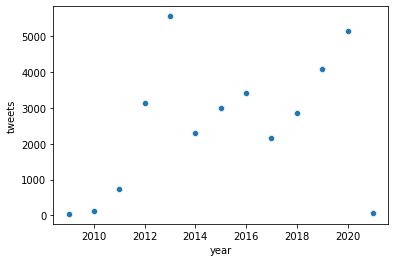

In [87]:
tweets_per_year = clean_df.groupby('year').agg('count')['id']
_ = sns.scatterplot(data=tweets_per_year)
plt.ylabel('tweets')
plt.show()

In [88]:
clean_df.to_csv('cleaned_tweets.csv', index=False)

In [92]:
full_df.to_csv('full_tweets.csv', index=False)

In [402]:
quotes = full_df[full_df.text.apply(lambda x: '"""' in x[:3])].text
print(quotes.iloc[10006])
print()
print(quotes.iloc[10007])

"""@ChadR73: Guess Barry Diller is afraid @realDonaldTrump is about to upset the crony applecart. #Trump2016 @Carl_C_Icahn"" An angry fool!"

"""@lewgeraldine: @FoxNews @realDonaldTrump TRUMP FOR ""PRESIDENT"" YOU HAVE MY VOTE."" GREAT."


In [403]:
len(quotes)

11558

In [302]:
# Quotes with responses
def is_quote_response(input_text):
    if '"""' not in input_text:
        return False
    if input_text[-2] != '"':
        return True
    else:
        return False

In [331]:
print(quotes[quotes.apply(lambda x: is_quote_response(x))].iloc[1])
print()
print(quotes[quotes.apply(lambda x: is_quote_response(x))].iloc[3004])
print()
print(quotes[quotes.apply(lambda x: is_quote_response(x))].iloc[3009])
print()
print(quotes[quotes.apply(lambda x: is_quote_response(x))].iloc[3014])
print()
print(quotes[quotes.apply(lambda x: is_quote_response(x))].iloc[3018])
print()
print(quotes[quotes.apply(lambda x: is_quote_response(x))].iloc[3027])
print()
print(quotes[quotes.apply(lambda x: is_quote_response(x))].iloc[3035])

"""Strive for wholeness and keep your sense of wonder intact."" --Donald J. Trump

"""@BrklynSportGeek Just heard you're bidding on @buffalobills. As a buffalo native thank you."" My honor."

"""@RustyWynnewood: Great day at Trump National in Charlotte. You took a good club and made it great. Well done sir.

"""@TrumpGolfLA: ICYMI: Fantastic commercial @TrumpGolfLA feat. @JordanSpieth & #tombrady Thanks @UnderArmour & @espn

"""@garc8509: @realDonaldTrump no don't buy the #BuffaloBills. Buy the #NewYorkMets #Mets we need a true owner that wants to win!! Please!"

"""Success breeds success. The best way to impress people is through results."" - Think Like a Billionaire"

"""@Michael_Haz Donald, why don’t you go out to Nevada & cut a deal for #CliveBundy? No one is a better deal maker than you. Go do it!"" True!"


### Types of quote tweets:

Full Quotes: Either start AND end in """, end in singular ", or ends in nothing.

Quote-reply: Starts with """ and has "" right before the reply.

Manual Quote Attribution: Has a quote wrapped by "" and then a manual text attribution, often with preceding -'s


In [567]:
def is_attribution(input_text):
    if input_text[:3] != '"""':
        return False
    if is_full_quote(input_text):
        return False
    attribution_flags = re.compile(r'"" -|""-|" -|"-|"" –|""–|" –|"–')
    result = attribution_flags.search(input_text)
    if result == None:
        return False
    else:
        return True
    

In [568]:
quotes.apply(lambda x: is_attribution(x)).sum()/len(quotes)

0.03114725731095345

In [569]:
def is_quote_reply(input_text):
    if input_text[:3] != '"""':
        return False
    if input_text[-1] != '"':
        return False
    if input_text[-3:] == '"""':
        return False
    if is_attribution(input_text):
        return False
    flags = re.compile(r'[^"]""[^"]')
    result = flags.search(input_text)
    if result == None:
        return False
    else:
        return True

In [570]:
quotes.apply(lambda x: is_quote_reply(x)).sum()/len(quotes)

0.31934590759646997

In [571]:
def is_full_quote(input_text):
    if input_text[:3] == '"""' and input_text[-3:] == '"""':
        return True
    else:
        return False


In [572]:
total_quotes = len(quotes)
attributions = quotes.apply(lambda x: is_attribution(x)).sum()
quote_reply = quotes.apply(lambda x: is_quote_reply(x)).sum()
full_quotes = quotes.apply(lambda x: is_full_quote(x)).sum()
print(f'Total: {total_quotes}')
print(f'Attributions: {attributions}')
print(f'Quote Replies: {quote_reply}')
print(f'Full Quotes: {full_quotes}')
print(f'Unaccounted For: {total_quotes - attributions - quote_reply - full_quotes}')

Total: 11558
Attributions: 360
Quote Replies: 3691
Full Quotes: 4886
Unaccounted For: 2621


In [573]:
remainders = quotes.apply(lambda x: not (is_attribution(x) | is_quote_reply(x) | is_full_quote(x)) )

In [585]:
foo = quotes[remainders]
bar = np.random.choice(foo, 5)
for item in bar:
    print(item)
    print()

"""America became a powerhouse because of our deep belief in the virtue of self-reliance."" #TimeToGetTough (cont)

"""@AndyShinberger: @realDonaldTrump people hate you because they are jealous of you and in reality they don't hate you, they hate themselves!"

"""@stkhlder3: @BrandiGlanville awww looks like such fun! #TeamBrandi I'm loving ya on @ApprenticeNBC !! Good job @realDonaldTrump"

"""@TheUSALifeStyle: @AnnCoulter TO #MakeAmericaGreatAgain VOTE FOR DONALD TRUMP. #Trump2016 #Eleccion2015 #USA #GOP

"""@EHarper69: @realDonaldTrump If you run you will win.. I've never been wrong. Just be presidential, not a salesman!"



In [582]:
remainders.sum()

2621

In [533]:
quotes[remainders].iloc[9]

'"""The damage that Democrats, weak Repubicans, and this disaster of a president have inflicted on America has put (cont)'

In [528]:
full_df.loc[full_df.text.apply(lambda x: 'President Reagan had it right:' in x)]

,id,text,device,likes,retweets,date,month,year
1024,157132000000000000,"""""""President Reagan had it right: Social Secur...",TwitLonger Beta,15,86,2012-01-11 16:10:00,1,2012


In [532]:
print(full_df.text.iloc[1024], full_df.text.iloc[1025], full_df.text.iloc[1026])

"""President Reagan had it right: Social Security is here to stay. We must root out the fraud and make it more (cont) """A real president should take pride in saving and spending your money wisely, not funneling it to his cronies (cont) 51% of @JonHuntsman's NH voters are satisfied with @BarackObama as president So is @JonHuntsman!


In [534]:
full_df.loc[full_df.text.apply(lambda x: 'The damage that Democrats, weak Repubicans, and this disaster' in x)]

,id,text,device,likes,retweets,date,month,year
1018,156820000000000000,"""""""The damage that Democrats, weak Repubicans,...",TwitLonger Beta,16,52,2012-01-10 19:29:00,1,2012


In [390]:
is_attribution('"""asdasda"" –BarnesandNoble.com')

True

In [443]:
clean_df.text.apply(lambda x: ('(cont)' in x)).sum()

328

In [444]:
clean_df.text.apply(lambda x: ('cont' in x[-10:]) & ('(cont)' not in x)).sum()

61

In [448]:
foo = clean_df[clean_df.text.apply(lambda x: ('cont' in x[-10:]) & ('(cont)' not in x))].text

The examples below were chosen from random sampling of the above filter.

In [488]:
clean_df.text.iloc[18292]

'The resolution being considered at the United Nations Security Council regarding Israel should be vetoed....cont:'

In [489]:
clean_df.text.iloc[18293]

'"Someone incorrectly stated that the phrase ""DRAIN THE SWAMP"" was no longer being used by me. Actually, we will always be trying to DTS."'

In [476]:
clean_df.text.iloc[17471]

"Hillary Clinton's weakness while she was Secretary of State, has emboldened terrorists all over the world..cont:"

In [477]:
clean_df.text.iloc[17472]

"Philly FOP Chief On Presidential Endorsement: Clinton ‘Blew The Police Off'"

In [494]:
clean_df.text.iloc[17658]

'The Palestinian terror attack today reminds the world of the grievous perils facing Israeli citizens....continued:'

In [495]:
clean_df.text.iloc[17659]

'Join me on #FacebookLive as I conclude my final #debate preparations.'

In [596]:
foo = full_df.text[full_df.text.apply(lambda x: is_retweet(x))]
bar = np.random.choice(foo,5)
for item in bar:
    print(item)
    print()

RT @NateSilver538: At this point, it's been 3.6 hours since the start of the caucuses and 1.9% of precincts have reported results, which ex…

RT @DGPurser: More lies about "Vote by mail".. . This is nothing but a Democrat attempt to cheat and STEAL this election.. . Nothing they say a…

RT @HawleyMO: It is amazing to watch Adam Schiff practically shove his co-managers aside to get to the microphone. His plan seems to be to…

RT @seanhannity: Biden's Ukraine warning 👇

RT @JudicialWatch: Right now, our borders are being used as gateways for drug cartels & violent criminals – each day adding to the millions...



### There appears to be no indication that 'cont' is used as a threading mechanism. Even after referencing back with the original df.

In [ ]:
# Special Tokens
QS = '<QS>'
QE = '<QE>'
reply = '<r>'